In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import csv
import sys
import pickle
import os
import random
import csv
import nltk
import fasttext
from numpy import linalg
from gensim.models.wrappers import FastText
from src import utils
import math
import re
import pickle
from sklearn.decomposition import PCA, FastICA
from sklearn.ensemble import VotingClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, cross_val_predict




In [3]:
csv.field_size_limit(sys.maxsize)
model_gensim = FastText.load_fasttext_format('./model')

In [4]:
tokenizer_s = nltk.data.load('tokenizers/punkt/english.pickle')
tokenize_pattern = re.compile("[A-Z]{2,}(?![a-z])|[A-Z][a-z]+(?=[A-Z])|[\'\w\-]+")

In [37]:
data_train = []
corpus = set([])
title = []
content = []
avesentlen = []
stdsentlen = []
titlelen = []
fake = []
with open('./FN_Training_Set.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for x in reader:
        data_train.append(x)
        title.append(re.findall(tokenize_pattern,x['Content Title']))
        content.append(re.findall(tokenize_pattern,x['Content']))
        sents = tokenizer_s.tokenize(x['Content'])
        sent_len = [len(re.findall(tokenize_pattern,sent)) for sent in sents]
        avesentlen.append(np.mean(sent_len))
        stdsentlen.append(np.std(sent_len))
        titlelen.append(len(title[-1]))
        fake.append(int(x['fake_news_score']))
        set.union(corpus,[s.lower() for s in title[-1]])
        set.union(corpus,set([s.lower() for s in content[-1]]))

/home/ubuntu/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/venv/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/venv/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/venv/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/venv/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [38]:
data_val = []
#corpus = set([])
title_val = []
content_val = []
avesentlen_val = []
stdsentlen_val = []
titlelen_val = []

with open('./FN_Validation_Set_noFNscore-2.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for x in reader:
        data_val.append(x)
        title_val.append(re.findall(tokenize_pattern,x['Content Title']))
        content_val.append(re.findall(tokenize_pattern,x['Content']))
        sents = tokenizer_s.tokenize(x['Content'])
        sent_len = [len(re.findall(tokenize_pattern,sent)) for sent in sents]
        avesentlen_val.append(np.mean(sent_len))
        stdsentlen_val.append(np.std(sent_len))
        titlelen_val.append(len(title[-1]))
        set.union(corpus,[s.lower() for s in title[-1]])
        set.union(corpus,set([s.lower() for s in content[-1]]))

In [7]:
article = content[0]
article = [word for word in article if len(word)>2]
art_array = np.zeros((len(article),100))
for i_ in range(len(article)):
    art_array[i_,:] = model_gensim[article[i_].lower()]

In [8]:
from sklearn.decomposition import PCA, FastICA
pca_article = PCA(n_components=100)

In [9]:
art_features = np.zeros((len(content),10000))
for j_ in range(len(content)):
    article = content[j_]
    article = [word for word in article if len(word)>2]
    art_array = np.zeros((max(100,len(article)),100))
    for i_ in range(len(article)):
        try:
            art_array[i_,:] = model_gensim[article[i_].lower()]
        except:
            pass
    art_array =  np.nan_to_num(art_array)
    art_features[j_,:] = pca_article.fit_transform(art_array.T).reshape(1,10000)
fake = np.asarray(fake)

/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/decomposition/pca.py:398: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [307]:
with open('./test_set.ids','rb') as f:
    test_idx = pickle.load(f)
train_idx = np.array([d for d in np.arange(len(fake)) if d not in test_idx])

In [89]:
def featuresFromText(texts,nwords=100):
    n_components = min(nwords,100)
    pca_text = PCA(n_components=n_components)
    features = np.zeros((len(texts),nwords*100))
    for j_ in range(len(texts)):
        text = texts[j_]
        text = [word for word in text if len(word)>2]
        text_array = np.zeros((max(nwords,len(text)),100))
        for i_ in range(len(text)):
            try:
                text_array[i_,:] = model_gensim[text[i_].lower()]
            except:
                pass
        text_array =  np.nan_to_num(text_array)
        features[j_,:] = pca_text.fit_transform(text_array.T).reshape(1,100*nwords)
    return features

In [95]:
title_features = featuresFromText(title,nwords=3)

In [ ]:
art_features = featuresFromText(content,nwords=100)

In [336]:
clf_title = SVC(kernel='rbf',probability=True,verbose=True,C=5,gamma=0.1)

In [337]:
cross_val_score(clf_title, title_features, fake, cv=5)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

array([ 0.68028419,  0.68206039,  0.70337478,  0.62166963,  0.63055062])

In [339]:
clf_title.fit(title_features[train_idx,:],fake[train_idx])

[LibSVM]

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [340]:
clf_title.score(title_features[test_idx,:],fake[test_idx])

0.66903914590747326

In [310]:
clf_title.score(title_features[train_idx,:],fake[train_idx])

0.95856353591160226

In [311]:
prob_title = clf_title.predict_proba(title_features[test_idx,:])

In [312]:
if 1:
    art_features_means = art_features.mean(axis=0)
    art_features_std = art_features.std(axis=0)
    art_norm = (art_features-art_features_means)/art_features_std
else:
    art_norm = art_features
pca_cum = PCA(n_components=500)
art_pca = pca_cum.fit(art_norm[train_idx,:])

In [313]:
clf2 = SVC(kernel='rbf',probability=True,verbose=True,C=10,gamma=1)

In [314]:
clf2.fit(art_pca.transform(art_norm[train_idx,:]),fake[train_idx])

[LibSVM]

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [315]:
clf2.score(art_pca.transform(art_norm[test_idx,:]),fake[test_idx])

0.697508896797153

In [316]:
clf2.score(art_pca.transform(art_norm[train_idx,:]),fake[train_idx])

0.9715864246250987

In [317]:
prob_content = clf2.predict_proba(art_pca.transform(art_norm[test_idx,:]))

In [318]:
total_features = np.concatenate([title_features,art_pca.transform(art_norm)],axis=1)

In [319]:
clf_total = SVC(kernel='rbf',probability=True,verbose=True,C=10,gamma=0.01)

In [320]:
clf_total.fit(total_features[train_idx,:],fake[train_idx])

[LibSVM]

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [321]:
clf_total.score(total_features[test_idx,:],fake[test_idx])

0.68683274021352314

In [322]:
clf_total.score(total_features[train_idx,:],fake[train_idx])

0.98303078137332278

In [323]:
prob_total = clf_total.predict_proba(total_features[test_idx,:])

In [324]:
with open('./svm_content_scores.p','wb') as f:
    probX = prob_content[:,1]
    probX = probX-probX.min()
    probX = probX/probX.max()
    pickle.dump(probX,f)
with open('./svm_title_scores.p','wb') as f:
    probX = prob_title[:,1]
    probX = probX-probX.min()
    probX = probX/probX.max()
    pickle.dump(probX,f)

In [202]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, n_jobs=4).fit(art_pca.transform(art_features[train_idx,:]),y=(fake[train_idx]==3).astype(int))

In [203]:
pred = kmeans.predict(art_pca.transform(art_features[test_idx,:]))

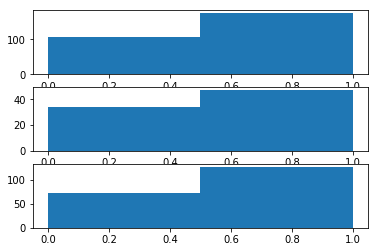

In [204]:
fig = plt.figure()
ax = [fig.add_subplot(3,1,i_+1)for i_ in range(3)]
ax[0].hist(pred,n_clusters)
ax[1].hist(pred[fake[test_idx]==1],n_clusters)
ax[2].hist(pred[fake[test_idx]==3],n_clusters)
plt.show()

In [212]:
((pred==0) != ((fake[test_idx]==3).astype(int))).sum()

161

In [325]:
with open('./results_by_forest.scores','rb') as f:
    results_by_forest = pickle.load(f)
with open('./results_by_title.scores','rb') as f:
    results_by_title = pickle.load(f)
with open('./results_by_url.scores','rb') as f:
    results_by_url = pickle.load(f)
probs = np.asarray([results_by_title,results_by_url,results_by_forest,prob_content[:,1],prob_title[:,1],prob_total[:,1]])
scores = probs>0.5

In [326]:
fake_test = fake[test_idx]==3

In [218]:
((scores != fake_test).all(axis=0)).sum()

5

In [219]:
(((scores.sum(axis=0))<3) & ((scores.sum(axis=0))>0)).sum()

82

In [300]:
def decide(scores, probs):
    conf = np.abs(0.5-probs)
    score = (scores*conf).sum(axis=0)/conf.sum(axis=0)
    score[score<0.5] = 0
    score[score>0.5] = 1
    return score
    

In [327]:
(decide(scores,probs) == fake_test).sum()/len(fake_test)

0.62989323843416367

In [304]:
svm_scores = SVC(kernel='rbf',degree=2,probability=True,verbose=True,C=1,gamma=10)

In [305]:
svm_scores.fit(probs.T,fake_test)

[LibSVM]

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma=10, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [328]:
svm_scores.score(probs.T,fake_test)

0.54804270462633453